# Algoritmo Genético para calcular el parámetro de Hubble $H(z)$

Avances hasta ahora: 

1. Empezamos con una poblacion base de funciones y otra de operaciones
2. Se crea la generación 0 combinando estas dos poblaciones bases
3. Se seleccionan individuos de la población 0 a partir del valor de su $\Chi^2$
4. Se elige un porcentaje de la población 0 que contiene menor chi
5. Se conservan los de menor $\Chi^2$ y al resto se les combina(en parejas) y muta aleatoriamente
6. Se crea generación nueva con los mutados/combinados y los con menor $\Chi^2$ de la generación anterior

Errores: 
1. No sé porqué a veces el chi me da un numero imaginario
2. El número de indivudos dentro de una generación se reduce muy rápido
3. El tiempo de ejecución aumenta drásticamente con el número de individuos de la población inicial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify
from sympy.abc import x
import time

In [2]:
# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

In [3]:
def Simplificador(poblacion):
    x = symbols('x')
    expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
    return expresiones_simplificadas

In [4]:
def Creador(num_poblacion_inicial, poblacion_base, operaciones):
    '''
    Creador recibe: 
    1. El numero de individuos que se desea que tenga la poblacion inicial
    2. Una lista con funciones base cuyas combinaciones crearan la poblacion inicial
    3. una lista con operaciones que actuarán sobre las funciones al momento de combinarlas
    '''
    poblacion_inicial= []
    for n in range(num_poblacion_inicial):
        expresion1 = random.choice(poblacion_base)
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            poblacion_inicial.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            poblacion_inicial.append(expresion)
            
    #poblacion_inicial = Simplificador(poblacion_inicial)
    return poblacion_inicial

In [5]:
def Seleccionador(poblacion_inicial, valores_observados, porcentaje_seleccion):
    '''
    Seleccionador recibe: 
    1. La poblacion inicial de funciones
    2. Los valores observados (que se esperan ajustar a una función)
    3. El porcentaje que se quiere de selección
    '''
    valores_x = valores_observados.tolist()
    Chi = np.zeros(len(poblacion_inicial))
    x = symbols('x')
    expresiones_sympy = [sympify(exp) for exp in poblacion_inicial] 
    
    for n , funcion in enumerate(expresiones_sympy):
        f = [funcion.subs(x, valor) for valor in valores_x]
        diferencia = np.abs([resultado - valor for resultado, valor in zip(z, f)])
        chi = np.sum(np.abs(diferencia/desv)**2)
        #chi_real, chi_imaginario = expresion = chi.as_real_imag()
        Chi[n] = chi

    seleccion = np.percentile(Chi, porcentaje_seleccion)
    seleccionados = Chi[Chi <= seleccion]
    indices = np.where(Chi <= seleccion)[0]
    funciones_seleccionadas = [poblacion_inicial[i] for i in indices]

    return funciones_seleccionadas, seleccionados

In [6]:
def Reproductor(funciones_seleccionadas, operaciones, porcentaje_combinacion, Chi_seleccionados, porcentaje_mutacion): 

    print('funciones_sleccionadas: ' + str(funciones_seleccionadas))
    #print(len(funciones_seleccionadas))

    #elegir el 20% con menor chi de los seleccionados
    mejor_seleccion = np.percentile(Chi_seleccionados, int(100 - porcentaje_combinacion)) 
    mejores_chi = Chi_seleccionados[Chi_seleccionados <= mejor_seleccion]
    mejores_indices = np.where(Chi_seleccionados <= mejor_seleccion)[0]
    mejores_funciones = [funciones_seleccionadas[i] for i in mejores_indices]

    #print('mejores_funciones: ' + str(mejores_funciones))
    #print(len(mejores_funciones))
        
    combinados = []
    num_combinados = int(len(funciones_seleccionadas)*(porcentaje_combinacion/100))
    funciones_a_combinar = np.delete(funciones_seleccionadas, mejores_indices)

    for n in range(0, len(funciones_a_combinar)):

        # Se eligen padres tal que sean funciones diferentes siempre
        expresion1 = funciones_a_combinar[n]
        indice = random.randint(0, len(funciones_a_combinar)-1)
        while indice == n:
            indice = random.randint(0, len(funciones_a_combinar)-1)
        expresion2 = funciones_a_combinar[indice]

        # Se elige operacion que los combinará
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            composicion = f1.subs(x, f2)
            combinados.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            combinados.append(expresion)

    #print('funciones_combinadas: ' + str(combinados))
    #print(len(combinados))

    # Se transforma combinados a numpy array
    combinados = np.array(combinados)


    # Empieza mutacion
    num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))

    mutaciones = []
    funciones_a_mutar = []

    # Se eligen (dentro de combinados) funciones a mutar tal que no sean iguales entre si
    for n in range(0, num_mutacion): 
        if n == 0:
            expresion1 = random.choice(combinados)
            funciones_a_mutar.append(expresion1)
        else:
            expresion1 = random.choice(combinados)
            while expresion1 in funciones_a_mutar:
                expresion1 = random.choice(combinados)
            funciones_a_mutar.append(expresion1)

        # Se elige una funcion base y una operacion base para mutar ###QUIZA ESTO SE TENGA QUE OPTIMIZAR###
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)

        #print('funciones_a_mutar: ' +str(funciones_a_mutar))

        if operacion == 'comp':
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            mutaciones.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            mutaciones.append(expresion)
    
    #print('funciones_mutadas: ' + str(mutaciones))
    #print(len(mutaciones))
            
    # Agrega los combinados que no fueron mutados y las mejores funciones seleccionadas al inicio
            
    indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
    funciones_sin_mutar = combinados[indices_no_mutados]
    funciones_sin_mutar = funciones_sin_mutar.tolist()
    
    mutaciones += funciones_sin_mutar + mejores_funciones

    nueva_generacion = Simplificador(mutaciones)
    #print('largo_nueva_generacion: ' + str(len(nueva_generacion)))

    return nueva_generacion

In [7]:
def GA_2(num_generaciones, num_poblacion_inicial, poblacion_base, operaciones, valores_observados, porcentaje_seleccion, porcentaje_combinacion, porcentaje_mutacion):

    #num_seleccion = int(num_poblacion_inicial*(porcentaje_seleccion/100))
    Poblacion = []
    Seleccion_funciones = []
    Seleccion_Chi = []
    Generacion = []
    
    for n in range(0, num_generaciones):
        print('NUMERO_DE_GENERACION:' +str(n))
        if n == 0:
            P = Creador(num_poblacion_inicial, poblacion_base, operaciones)
            Poblacion.append(P)

            S = Seleccionador(Poblacion[n], valores_observados, porcentaje_seleccion)
            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)

            Generacion.append(R)

            print('NUEVA_GENERACION:' + str(Generacion[n]))

        else: 

            S = Seleccionador(Generacion[n-1], valores_observados, porcentaje_seleccion)
            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            if len(Seleccion_funciones[n]) == 1:
                print("Deteniendo el código porque len(Generacion[n]) == 1")
                break

            # Evaluar si todos los elementos de Seleccion_funciones son iguales al final de la iteración
            if all(elemento == Seleccion_funciones[n][0] for elemento in Seleccion_funciones[n]):
                print("Deteniendo el código porque todos los elementos de Seleccion_funciones son iguales al final de la iteración")
                break

            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)
            
            Generacion.append(R)

            print('NUEVA_GENERACION:' + str(Generacion[n]))
            print('LONGITUD DE FUNCIONES SELECCIONADAS: ' +str(len(Seleccion_funciones[n])))
    

    
    Generacion[n-1] = Simplificador(Seleccion_funciones[n])
    print('NUEVA_GENERACION: ' +str(Seleccion_funciones[n]))

    return Generacion[-1]

## Pruebas del código

In [9]:
poblacion_base_borrador = ['x**3', 'x**4', 'x', 'x**2', 'log(x)']

poblacion_base = ['exp(x)', 'log(x)', 'x**2', 'x**3']

operaciones = ['*', '/', '**', '+', '-', 'comp'] 

tercer_intento = GA_2(4, 80, poblacion_base, operaciones, z, 20, 80, 10)

NUMERO_DE_GENERACION:0
funciones_sleccionadas: ['exp(x) ** log(x)', 'x**3 / x**2', 'exp(x) - exp(x)', 'x**3 / x**2', 'log(exp(x))', 'log(x) / exp(x)', 'log(x) - log(x)', 'log(x) / exp(x)', 'x**2 - log(x)', 'log(x) ** x**2', 'x**2 * log(x)', 'exp(x) / exp(x)', 'log(x) ** x**2', 'x**2 * log(x)', 'exp(x) - exp(x)', 'x**2 / x**2', 'x**2 / x**2']
NUEVA_GENERACION:[-log(x)**(x**2 - 1), exp(x)**log(x) + exp(-x)*log(x), 0, exp(-log(x)**(x**2))*log(log(x)**(x**2)), -log(x) + log(x)/exp(x)**(x**2), x**2 - log(x) - log(x)**(x**2), log(x)**(x**2) - exp(-x)*log(x), x**2*log(x) + exp(x)**log(x), log(x)**(x**2), log(x)**(2*x**2)*log(log(x)**(x**2)), (1 - log(x)**(x**2))*exp(x), x, x, log(exp(x)), 1, 1, 1]
NUMERO_DE_GENERACION:1
funciones_sleccionadas: [x, x, log(exp(x)), 1, 1, 1]
NUEVA_GENERACION:[log(exp(x)), 1, 1, 1, x, x]
LONGITUD DE FUNCIONES SELECCIONADAS: 6
NUMERO_DE_GENERACION:2
Deteniendo el código porque todos los elementos de Seleccion_funciones son iguales al final de la iteración
NUEVA_GE

In [10]:
# Elegir mejor

print(tercer_intento)

# Convertir de expresiones sympy a funciones de Python
funciones_python = [lambdify(x, expresion, 'numpy') for expresion in tercer_intento]

best_fit = funciones_python[0]
evaluada = best_fit(z)

[x, x]


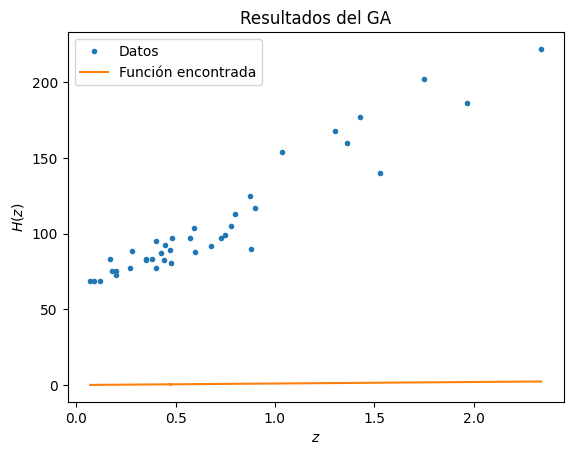

In [11]:
# Graficar Resultados

plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.show()